<a href="https://colab.research.google.com/github/aditya9049/image-colorization/blob/main/CA_2_CVPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

DATA_DIR = '/content/drive/MyDrive/data'



In [19]:
!pip install matplotlib-venn
!pip install tensorflow

# Now import the libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate,MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam


In [4]:
# Constants
IMAGE_SIZE = 128
DATA_DIR = '/content/drive/MyDrive/data'

In [5]:
def load_images(folder, color_mode='rgb'):
    images = []
    for filename in sorted(os.listdir(folder)):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        if color_mode == 'gray':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

In [6]:
# Load images from Drive
x_train = load_images(os.path.join(DATA_DIR, 'train_black'), color_mode='gray')
y_train = load_images(os.path.join(DATA_DIR, 'train_color'), color_mode='rgb')
x_test = load_images(os.path.join(DATA_DIR, 'test_black'), color_mode='gray')
y_test = load_images(os.path.join(DATA_DIR, 'test_color'), color_mode='rgb')

print("Train Gray:", x_train.shape)
print("Train Color:", y_train.shape)

Train Gray: (5000, 128, 128, 1)
Train Color: (5000, 128, 128, 3)


In [8]:
# Autoencoder Architecture
from tensorflow.keras.layers import  BatchNormalization, Dropout

input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x) # Use Dropout here
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,139 (1.14 MB)

 Trainable params: 298,371 (1.14 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,139 (1.14 MB)

 Trainable params: 298,371 (1.14 MB)

 Non-trainable params: 768 (3.00 KB)

In [10]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history=autoencoder.fit(x_train, y_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                callbacks=[early_stop, reduce_lr])

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - loss: 0.0247 - val_loss: 0.0522 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.0131 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0125 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0119 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0117 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0116 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0109 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0106 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0104 - val_loss: 0.0119 - learning_rate:

In [11]:
# Prediction
decoded_imgs = autoencoder.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


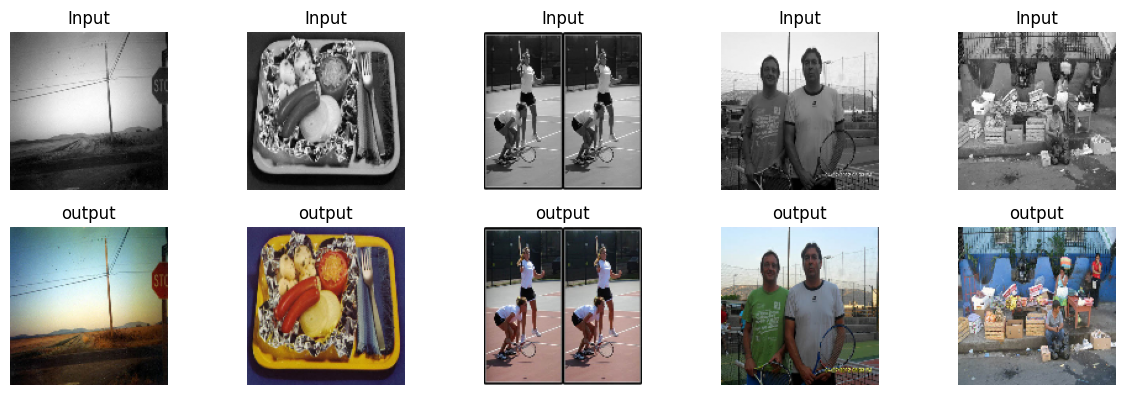

In [12]:
# Visualize results
n = 5
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i])
    plt.title("output")
    plt.axis('off')


plt.tight_layout()
plt.show()

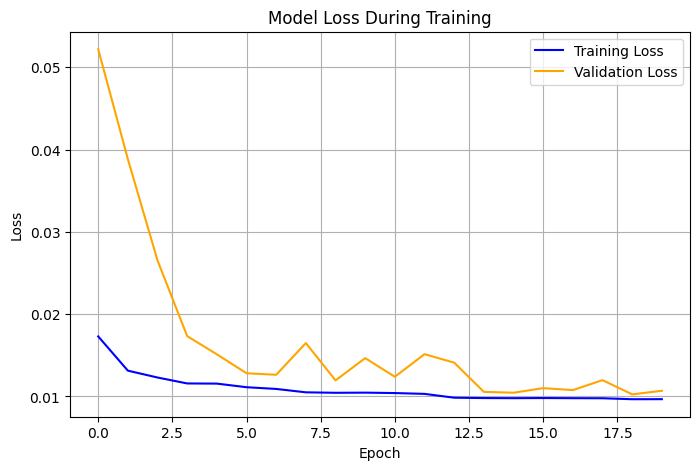

In [13]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [14]:

# U-Net Architecture
def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)


In [22]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.3)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Output Layer
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

In [28]:
# Build the U-Net model
unet_model = unet()
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
unet_model.summary()

# Reshape x_train to have 1 channel if it has 3 channels
if x_train.shape[-1] == 3:  # Check if x_train has 3 channels (RGB)
    x_train = x_train[:, :, :, 0:1]  # Select only the first channel (grayscale)
x_train = x_train.astype('float32')



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64, 64,    │          0 │ max_pooling2d_22… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_18[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32, 32,    │          0 │ max_pooling2d_23… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 32, 32,    │    295,168 │ dropout_19[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_81[0][0] 

 Total params: 7,793,155 (29.73 MB)

 Trainable params: 7,787,523 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [29]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train the model
unet_model.fit(x_train, y_train,
               epochs=10,
               batch_size=16,
               validation_data=(x_test, y_test),
               callbacks=[early_stopping, reduce_lr],
               shuffle=True)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 342ms/step - loss: 0.0219 - val_loss: 0.0454 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 94s 220ms/step - loss: 0.0091 - val_loss: 0.0097 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 208ms/step - loss: 0.0087 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 202ms/step - loss: 0.0084 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 215ms/step - loss: 0.0083 - val_loss: 0.0070 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 212ms/step - loss: 0.0081 - val_loss: 0.0080 - learning_rate: 1.0000e-04
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - loss: 0.0080 - val_loss: 0.0067 - learning_rate: 5.0000e-05
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 203ms/step - loss: 0.0077 - val_loss: 0.0068 - learning_rate: 5.0000e-05
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 207ms/step - loss: 

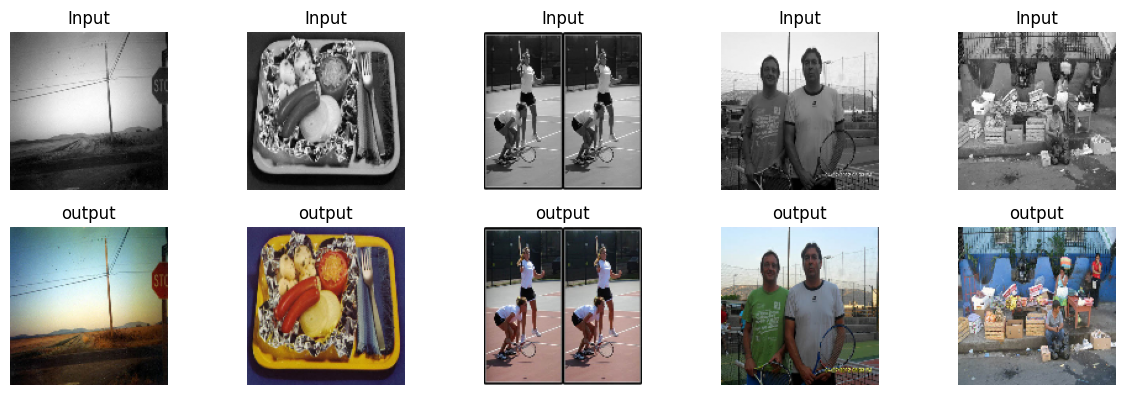

In [30]:
# Visualization
n = 5
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i])
    plt.title("output")
    plt.axis('off')



plt.tight_layout()
plt.show()

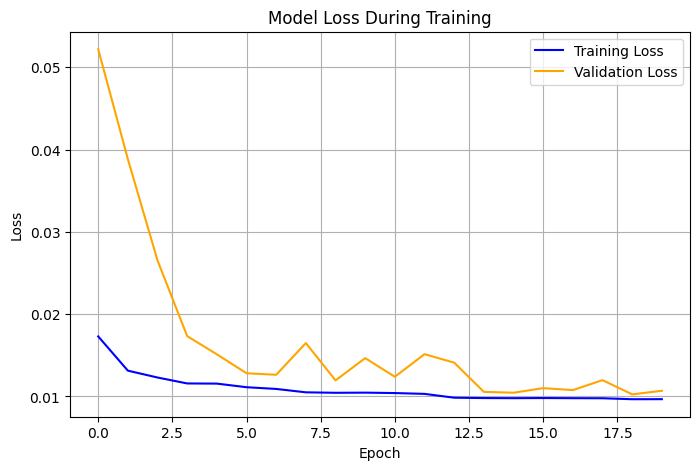

In [31]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()